In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../../../do-mpc_fork/')
import do_mpc
import pandas as pd
import scipy.io as sio
import pathlib
import pandas as pd

In [2]:
%matplotlib notebook

In [3]:
plan_name = 'kite_validation_01'
model_name = 'S01_NN_M01'
load_name = f'./{plan_name}/{plan_name}.pkl'

plan = do_mpc.tools.load_pickle(load_name)
    
dh_bll = do_mpc.sampling.DataHandler(plan)
dh_bll.set_param(data_dir = f'./{plan_name}/{model_name}/with_bll_cons/')

dh_std = do_mpc.sampling.DataHandler(plan)
dh_std.set_param(data_dir = f'./{plan_name}/{model_name}/wo_bll_cons/')

In [4]:
for dh in [dh_bll, dh_std]:
    dh.set_post_processing('T_F', lambda data: data[0]['_aux', 'T_F'])
    dh.set_post_processing('height', lambda data: data[0]['_aux', 'height_kite'])
    dh.set_post_processing('traj_len', lambda data: data[0]['_x'].shape[0])
    dh.set_post_processing('T_f_tot', lambda data: np.sum(data[0]['_aux', 'T_F']))
    dh.set_post_processing('states', lambda data: data[0]['_x'])
    dh.set_post_processing('bll_trust', lambda data: data[1]['_aux','bll_trust'])
    
    
df_std = pd.DataFrame(dh_std[:])
df_bll = pd.DataFrame(dh_bll[:])

<IPython.core.display.Javascript object>


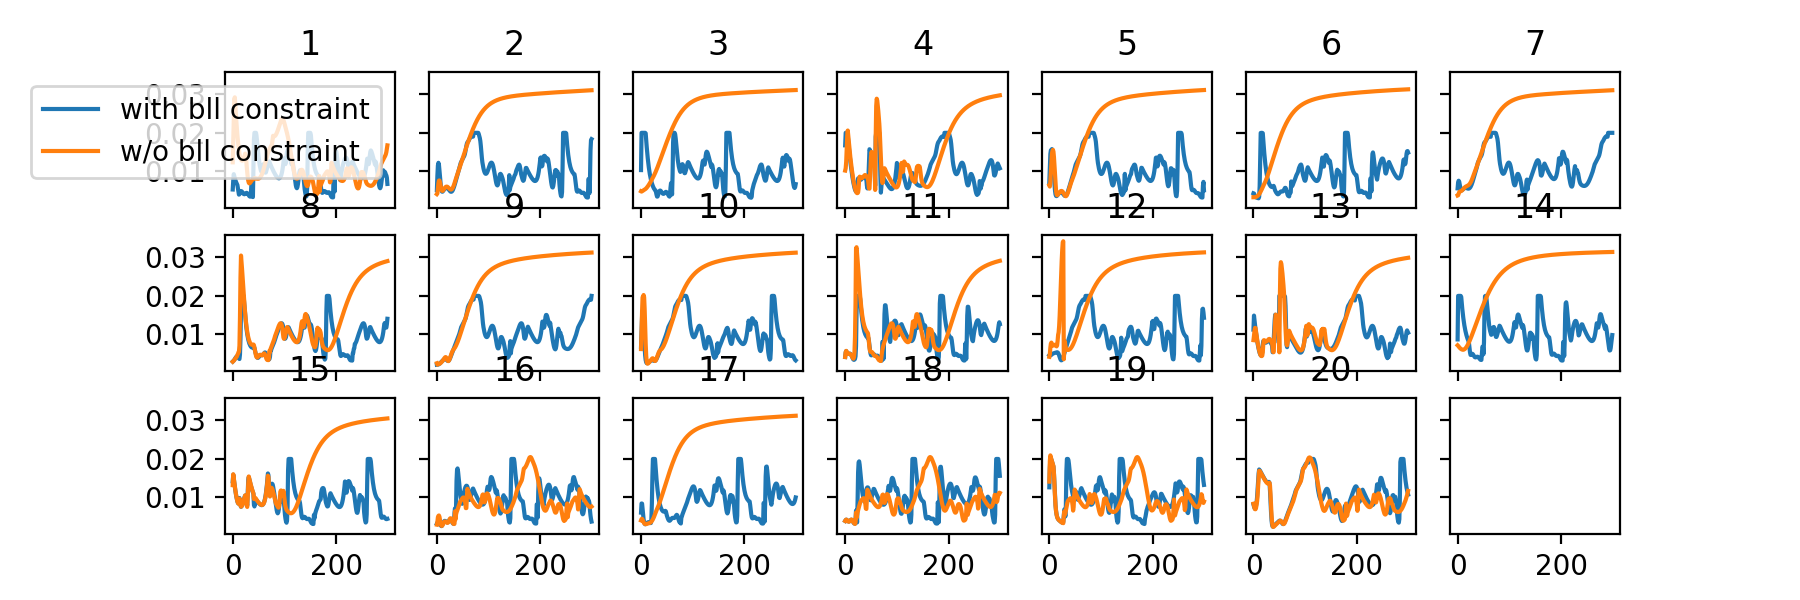

In [5]:
n_res = min(len(df_std),20)

n_row = int(np.ceil(np.sqrt(n_res)))
n_row = 3
n_col = int(np.ceil(n_res/n_row))

fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(9,3))

for dh in [dh_bll, dh_std]:
    for i in range(n_res):
        ax[i//n_col, np.mod(i,n_col)].plot(dh[i][0]['bll_trust'])
        ax[i//n_col, np.mod(i,n_col)].set_title(i+1)


ax[0,0].set_prop_cycle(None)
ax[0,0].plot([],[],label='with bll constraint')
ax[0,0].plot([],[],label='w/o bll constraint')
ax[0,0].legend()

<IPython.core.display.Javascript object>


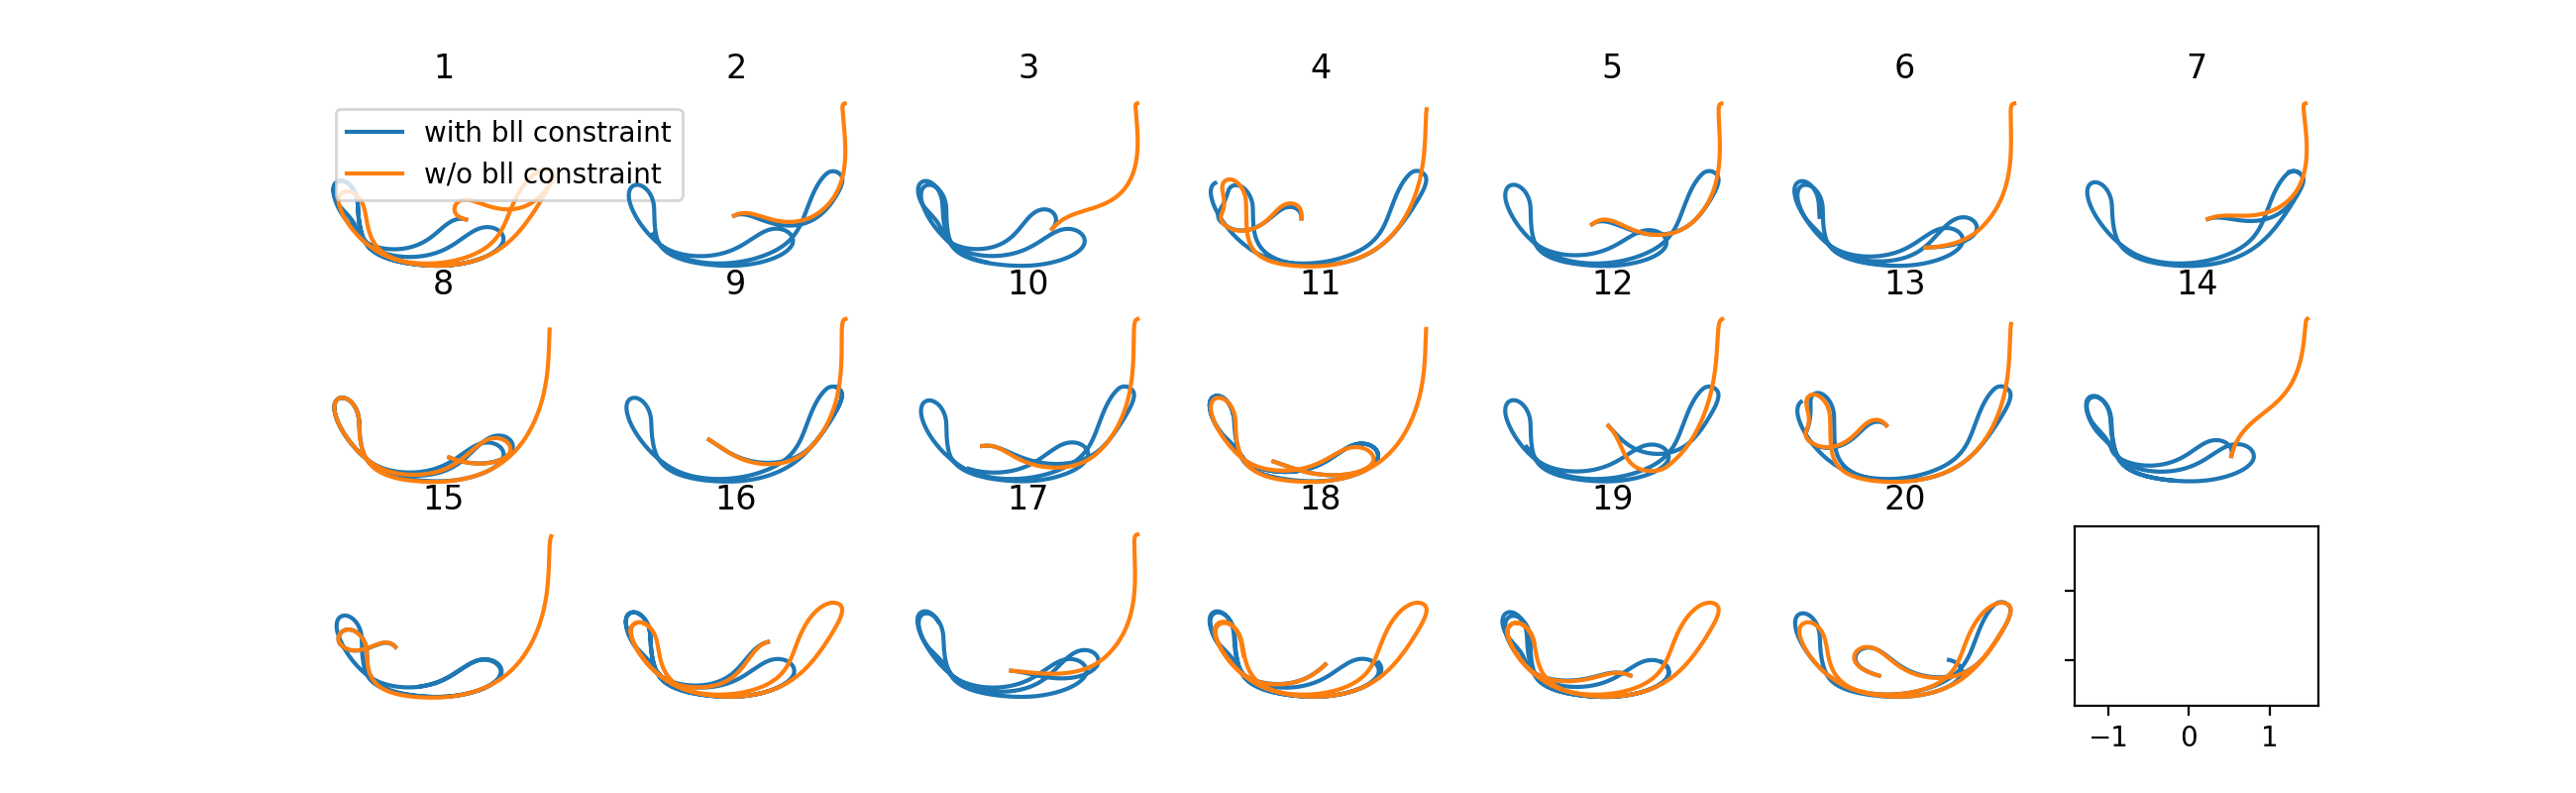

In [6]:
n_res = min(len(df_bll),20)

n_row = int(np.ceil(np.sqrt(n_res)))
n_row = 3
n_col = int(np.ceil(n_res/n_row))

offset = 0

fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(13,4))

for dh in [dh_bll, dh_std]:
    for i in range(n_res):
        ax[i//n_col, np.mod(i,n_col)].plot(dh[i+offset][0]['states'][:,1],dh[i+offset][0]['states'][:,0])
        ax[i//n_col, np.mod(i,n_col)].axis('off')
        ax[i//n_col, np.mod(i,n_col)].set_title(i+1)


ax[0,0].set_prop_cycle(None)
ax[0,0].plot([],[],label='with bll constraint')
ax[0,0].plot([],[],label='w/o bll constraint')
ax[0,0].legend()
    
#fig.tight_layout(pad=0)



In [7]:
T_f_tot_std = df_std['T_f_tot']
T_f_tot_bll = df_bll['T_f_tot']

<IPython.core.display.Javascript object>


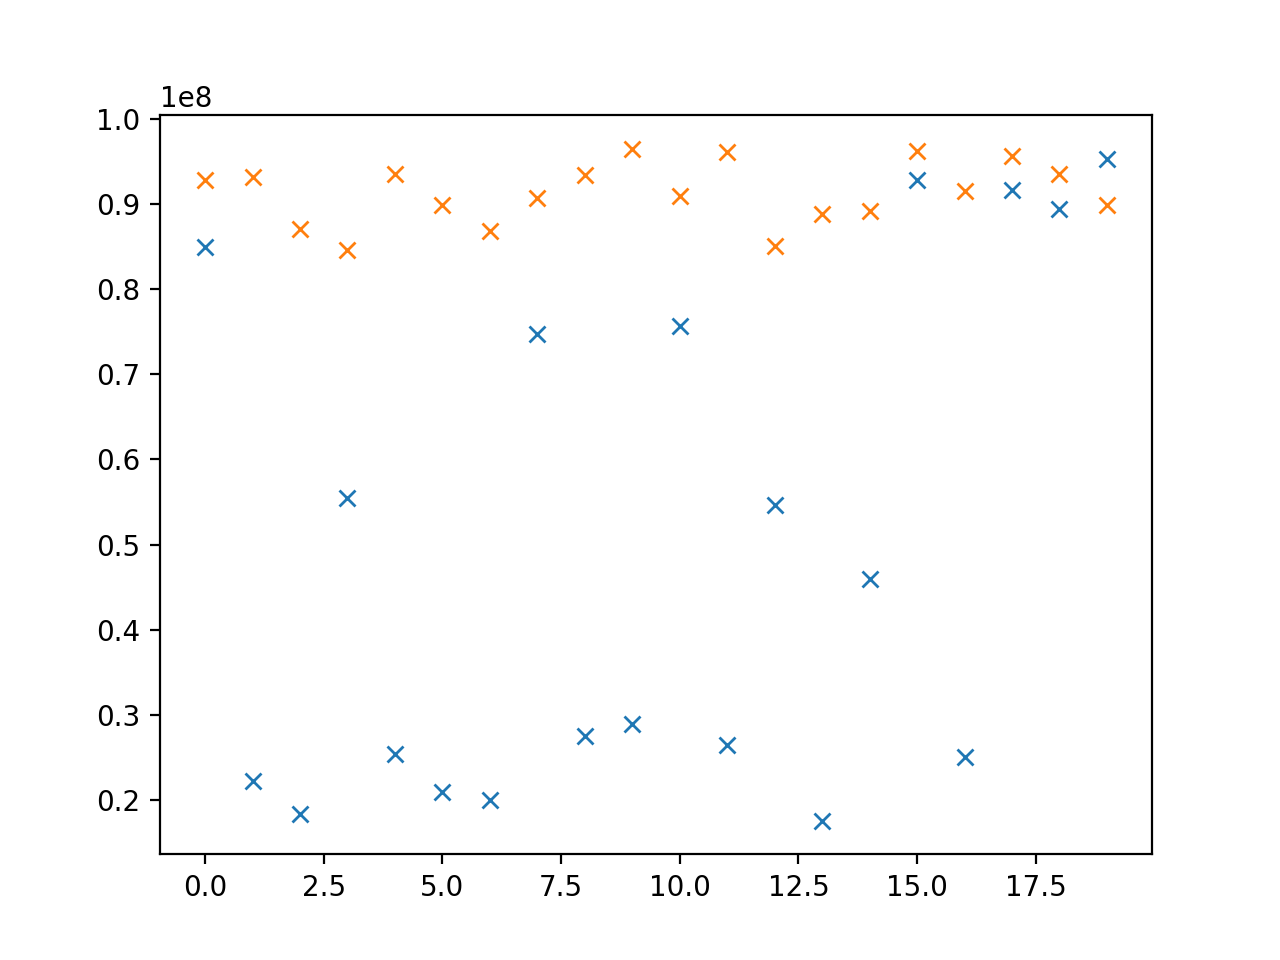

In [8]:
fig,ax = plt.subplots()

ax.plot(T_f_tot_std, 'x')
ax.plot(T_f_tot_bll, 'x')

In [9]:
dh_bll[0]

[{'seed': 642,
  'x0': array([[0.5712127 ],
         [0.37178186],
         [1.17652698]]),
  'id': '000',
  'T_F': array([[303417.46971006],
         [190160.78304451],
         [124393.99262572],
         [124393.72040437],
         [124598.6005127 ],
         [125009.67883537],
         [125627.02851189],
         [126449.69704358],
         [127475.65765733],
         [131946.73108904],
         [174807.2655207 ],
         [243493.05744409],
         [312230.24901692],
         [363199.23493092],
         [397436.70667564],
         [421910.41652631],
         [440639.5213686 ],
         [455321.81522417],
         [466715.48673894],
         [475241.72009083],
         [481097.82284435],
         [484654.43355784],
         [486461.80031655],
         [486899.73122714],
         [486413.47396306],
         [485708.40635259],
         [485283.92873733],
         [485338.14949544],
         [485855.98914896],
         [486580.74218101],
         [487013.53945351],
         [486535.2

<IPython.core.display.Javascript object>


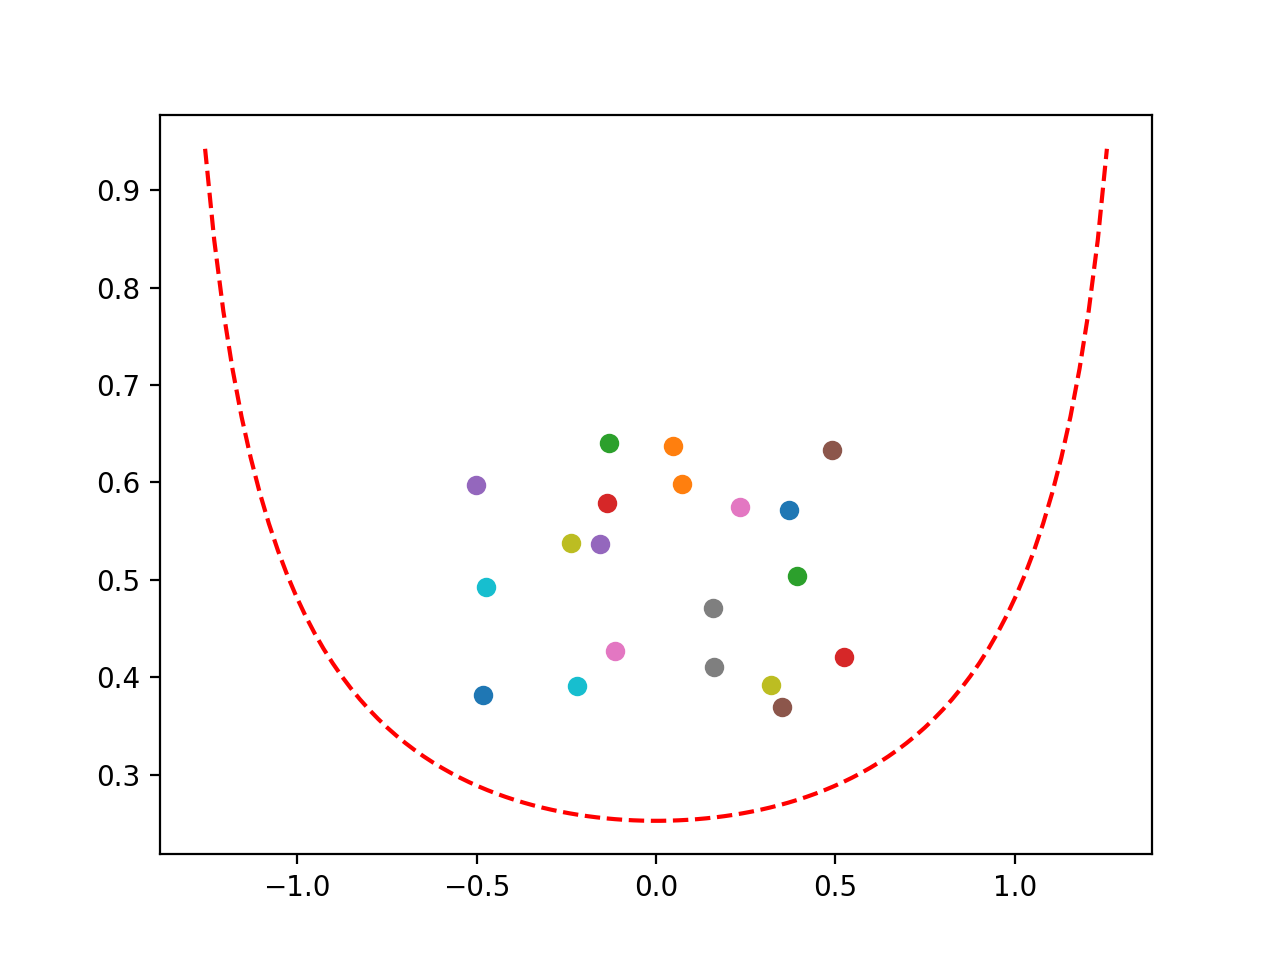

In [10]:
fig, ax = plt.subplots()

phi_height_limit = np.linspace(-0.4*np.pi,0.4*np.pi, 100)
L_tether = 400
h_min = 100
theta_height_limit = np.arcsin(h_min/(np.cos(phi_height_limit)*L_tether))
ax.plot(phi_height_limit,theta_height_limit, linestyle='--', color='r')


for i in range(n_res):
    x0 = dh_bll[i][0]['x0']
    ax.scatter(x0[1],x0[0])